# Training


### Building and compiling a model

In [1]:
%%capture
from librosa.core import time_to_frames
from chimeranet.model import ChimeraNetModel
time, sr, hop_length, n_mels = 0.75, 16000, 128, 96
T, F, C, D = time_to_frames(time, sr, hop_length), n_mels, 2, 20
cm = ChimeraNetModel(T, F, C, D)
# build_model returns Keras' Model object
model = cm.build_model(n_blstm_units=50, n_blstm_layers=2)
model.compile(
    'rmsprop',
    loss={
        'embedding': cm.loss_deepclustering(),
        'mask': cm.loss_mask()
    },
    loss_weights={
        'embedding': 0.5,
        'mask': 0.5
    }
)

### Training a model

In [2]:
%%capture
import h5py
# load data first
y_train, y_validation = dict(), dict()
with h5py.File('example-dataset.h5') as f:
    x_train = f['x_train'][()]
    y_train['embedding'] = f['y_train_embedding'][()]
    y_train['mask'] = f['y_train_mask'][()]
    x_validation = f['x_validation'][()]
    y_validation['embedding'] = f['y_validation_embedding'][()]
    y_validation['mask'] = f['y_validation_mask'][()]
# train model by model.fit function
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_validation, y_validation),
    batch_size=4,
    epochs=5
)
# finally, save the model
model.save('example-model.h5')

### Training an existing model

Since ChimeraNet uses custom loss function, `CustomObjectScope` is necessary.

```
Currently, ChimeraNetModel wraps partial thing of keras' model.
This procedure might be wrapped on future release.
```

In [3]:
%%capture
from keras.models import load_model
from keras.utils import CustomObjectScope
with CustomObjectScope({
    '_loss_deepclustering': cm.loss_deepclustering(),
    '_loss_mask': cm.loss_mask(),
}):
    model = load_model('example-model.h5')
model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_validation, y_validation),
    batch_size=1,
    initial_epoch=3,
    epochs=3+1
)

### On learning curve

Also, you can plot learning curve. for more information, see keras documentation

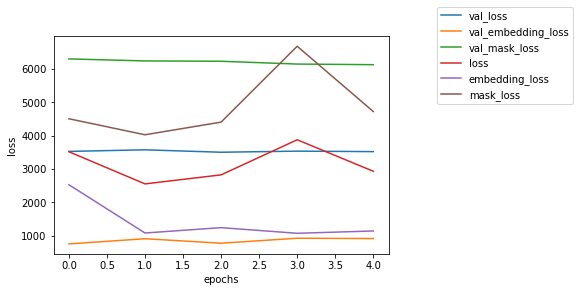

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
for k, v in history.history.items():
    plt.plot(v, label=k)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)